In [29]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

The exact formulation of the problem will be as follows: given data covering the previ-
ous five days and sampled once per hour, can we predict the temperature in 24 hours?

In [30]:
path = 'dataset/weather-timeseries/jena_climate_2009_2016.csv/jena_climate_2009_2016.csv'
df = pd.read_csv(path)

print(df.shape)
df.head()

(420451, 15)


,Date Time,p (mbar),T (degC),Tpot (K),Tdew (degC),rh (%),VPmax (mbar),VPact (mbar),VPdef (mbar),sh (g/kg),H2OC (mmol/mol),rho (g/m**3),wv (m/s),max. wv (m/s),wd (deg)
0,01.01.2009 00:10:00,996.52,-8.02,265.40,-8.90,93.3,3.33,3.11,0.22,1.94,3.12,1307.75,1.03,1.75,152.3
1,01.01.2009 00:20:00,996.57,-8.41,265.01,-9.28,93.4,3.23,3.02,0.21,1.89,3.03,1309.80,0.72,1.50,136.1
2,01.01.2009 00:30:00,996.53,-8.51,264.91,-9.31,93.9,3.21,3.01,0.20,1.88,3.02,1310.24,0.19,0.63,171.6
3,01.01.2009 00:40:00,996.51,-8.31,265.12,-9.07,94.2,3.26,3.07,0.19,1.92,3.08,1309.19,0.34,0.50,198.0
4,01.01.2009 00:50:00,996.51,-8.27,265.15,-9.04,94.1,3.27,3.08,0.19,1.92,3.09,1309.00,0.32,0.63,214.3


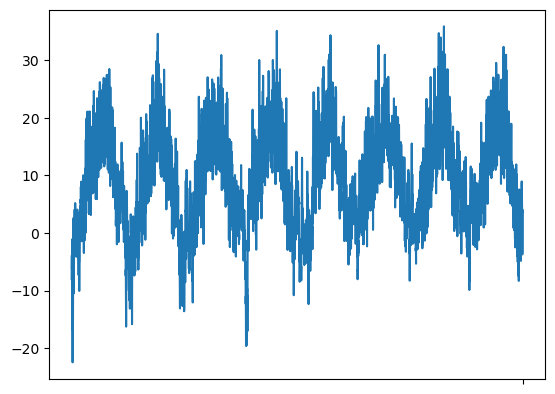

In [31]:
dates = df['Date Time'].values
y = df['T (degC)'].values
X = df.drop(columns = ['Date Time']).values # includes the temp

indexes = list(range(0, len(dates), 100))
plt.plot(dates[indexes], y[indexes])
plt.xticks('')
plt.show()

Plot the first ten days.

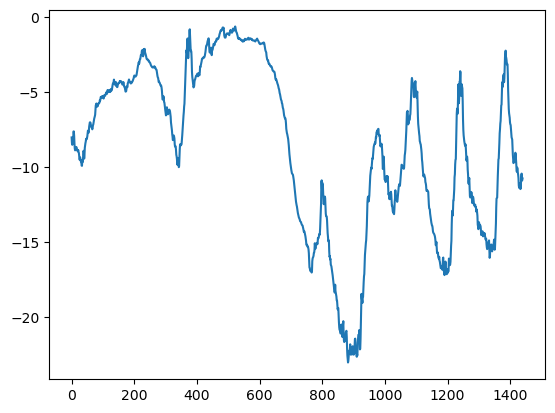

In [32]:
plt.plot(range(1440), y[:1440])

In [33]:
num_train_samples = int(0.5 * len(X))
num_val_samples = int(0.25 * len(X))
num_test_samples = len(X) - num_train_samples - num_val_samples
print("num_train_samples:", num_train_samples)
print("num_val_samples:", num_val_samples)
print("num_test_samples:", num_test_samples)

num_train_samples: 210225
num_val_samples: 105112
num_test_samples: 105114


Normalize the data.

In [34]:
mean = X[:num_train_samples].mean(axis = 0)
X -= mean

std = X[:num_test_samples].std(axis = 0)
X /= std

print(X.mean(axis = 0))
print(X.std(axis = 0))

[ 0.05434383  0.06898299  0.06497788  0.08765913  0.00828766  0.05636842
  0.08090275  0.01937032  0.07965933  0.07967158 -0.05714411 -0.01265847
 -0.012232   -0.0192723 ]
[0.98072395 0.93323312 0.94286862 0.92085    1.01687714 1.01600387
 1.00031509 1.04242708 1.00213162 1.00156244 0.95898426 1.0026489
 1.01883089 0.97438325]


In [35]:
from keras.utils import timeseries_dataset_from_array

sampling_rate = 6  # data is per 10 minutes, here we take per 1 hour
sequence_length = 120  # 120 hours = 5 days
delay = sampling_rate * (sequence_length + 24 - 1)  # target = 24 h after end of seq
batch_size = 256

train_dataset = timeseries_dataset_from_array(
    X[:-delay],
    targets=y[delay:],
    sampling_rate=sampling_rate,
    sequence_length=sequence_length,
    shuffle=True,
    batch_size=batch_size,
    start_index=0,
    end_index=num_train_samples,
)
val_dataset = timeseries_dataset_from_array(
    X[:-delay],
    targets=y[delay:],
    sampling_rate=sampling_rate,
    sequence_length=sequence_length,
    shuffle=True,
    batch_size=batch_size,
    start_index=num_train_samples,
    end_index=num_train_samples + num_val_samples,
)
test_dataset = timeseries_dataset_from_array(
    X[:-delay],
    targets=y[delay:],
    sampling_rate=sampling_rate,
    sequence_length=sequence_length,
    shuffle=True,
    batch_size=batch_size,
    start_index=num_train_samples + num_val_samples,
)

In [36]:
for samples, targets in train_dataset:
    print(f'samples shape : {samples.shape}')
    print(f'targets shape : {targets.shape}')
    break

samples shape : (256, 120, 14)
targets shape : (256,)


In [37]:
# Understanding timeseries_dataset_from_array()

int_sequence = np.arange(10)
dummy_dataset = keras.utils.timeseries_dataset_from_array(
    data=int_sequence[:-3],
    targets=int_sequence[3:],
    sequence_length=3,
    batch_size=2,
)

for inputs, targets in dummy_dataset:
    for i in range(inputs.shape[0]):
        print([int(x) for x in inputs[i]], int(targets[i]))

[0, 1, 2] 3
[1, 2, 3] 4
[2, 3, 4] 5
[3, 4, 5] 6
[4, 5, 6] 7


In [68]:
def evaluate_naive_method(dataset):

    total_abs_error = 0
    samples_seen = 0

    for samples, targets in dataset:
        preds = samples[:, -1, 1] # all samples, last observation, column 1 (temp)
        # print(samples.shape) 
        # print(targets.shape)
        # print(preds.shape)
        
        # scale back to celcius by std and mean of entire train ds
        preds = preds * std[1] + mean[1] 

        error = np.sum(np.abs(preds - targets))
        total_abs_error += error
        samples_seen += samples.shape[0]
        
    return total_abs_error / samples_seen # MAE

print(f"Validation MAE: {evaluate_naive_method(val_dataset):.2f}")
print(f"Test MAE: {evaluate_naive_method(test_dataset):.2f}")

Validation MAE: 2.44
Test MAE: 2.62
